# MSER-文本提取

In [1]:
#coding:utf-8
import numpy as np
%matplotlib  inline
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import pytesseract
from skimage.color import rgb2lab

In [2]:
def transform(img):
    """归一化尺寸，将图片缩放到统一尺寸 """
    h, w, c = np.shape(img)
    f_h = 1920
    f_y = float(h) / 1920
    f_w = int(float(w) / f_y)
    resize_img = cv2.resize(img, (f_w, f_h), interpolation=cv2.INTER_AREA)
    return resize_img

In [3]:
def hyp_parameters(resize_img):
    """ 计算经验参数 """
    h, w, c = resize_img.shape
    # 文字区块最小最大面积
    min_area, max_area = 27*27, 0.05 * h * w
    # 文字区块最小最大高度
    min_h, max_h = 50, 200
    return min_area, max_area, min_h, max_h

In [4]:
def find_candidates(resize_img):
    """ 返回候选文字区块坐标 """

    # 灰度化
    gray = cv2.cvtColor(resize_img, cv2.COLOR_BGR2GRAY)

    # 二值化
    _threshold = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)[1]

    # 腐蚀
    kernel = np.ones((27, 27), np.uint8)
    erosion = cv2.erode(_threshold, kernel, iterations = 2)

    # 轮廓检测
    _, contours, hierarchy = cv2.findContours(erosion, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # 根据经验参数选取区域
    candidate_boxes = []
    min_area, max_area, min_h, max_h = hyp_parameters(resize_img)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if min_area < cv2.contourArea(cnt) < max_area and min_h < h < max_h:
            candidate_boxes.append((x,y,x+w,y+h))

    return candidate_boxes

In [5]:
def split_candidates(resize_img,box):
    """ 候选区块切割 """

    # 灰度化
    gray = cv2.cvtColor(resize_img, cv2.COLOR_BGR2GRAY)
    # 二值化
    _threshold = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)[1]

    # 腐蚀
    kernel = np.ones((3, 5), np.uint8)
    erosion = cv2.erode(_threshold, kernel, iterations = 2)

    # 获取区块对应腐蚀图像
    x1, y1, x2, y2 = box
    box_erosion = erosion[y1:y2, x1:x2]

    # 依据连续空白区域进行列切割
    his = np.mean(box_erosion, axis=0)
    split_indexes, flag = [0], True
    for i in range(len(his)):
        c = his[i]
        if c != 255 and flag is True:
            split_indexes.append(i)
            flag = False
        elif c == 255 and flag is False:
            split_indexes.append(i)
            flag = True
    split_indexes.append(len(his))

    assert len(split_indexes) % 2 == 0

    t = [int((i+j)/2) for i,j in zip(split_indexes[::2],split_indexes[1::2])]

    boxes = [(x1+t[i], y1, x1+t[i+1], y2) for i in range(len(t)-1) if t[i+1]-t[i]]

    return boxes

In [6]:
def is_noisy(resize_img,box):
    """ 基于坐标规则判断是否属于人脸噪声区块 """
    h, w, c = np.shape(resize_img)
    x1, y1, x2, y2 = box
    if (x1+x2)/2 > 0.65*w and (y1+y2)/2 < 0.7*h:
        return True
    return False


In [7]:
def detect(resize_img):
    # 初步查找候选区域
    candidate_boxes = find_candidates(resize_img)

    # 初步候选区域切割
    split_boxes = []
    for candidate in candidate_boxes:
        if candidate[2]-candidate[0] > 100:
            split_boxes += split_candidates(resize_img,candidate)
        else:
            split_boxes += [candidate]

    # 屏蔽人脸区域噪音
    final_boxes = []
    for box in split_boxes:
        if not is_noisy(resize_img,box):
            final_boxes.append(box)

    return final_boxes

In [8]:
rgb = cv2.imread('../datas/ID.jpg')
rgb = cv2.cvtColor(rgb,cv2.COLOR_BGR2RGB)

In [9]:
boxes = detect(rgb)

In [10]:
for box in boxes:
    cv2.rectangle(rgb, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 3)

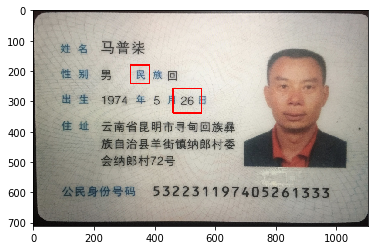

In [11]:
plt.imshow(rgb)

In [28]:
def mser(cv_image):
    vis = cv_image.copy()
    #mser = cv2.MSER_create()
    mser = cv2.MSER_create(_delta = 5, _min_area = 100, _max_area=14400, 
                           _max_variation = 0.15, _min_diversity = .4, 
                           _max_evolution = 200,  _area_threshold = 1.01, 
                           _min_margin = 0.003, _edge_blur_size = 5)
    regions, _ = mser.detectRegions(cv_image)
    for p in regions:
        xmax, ymax = np.amax(p, axis=0)
        xmin, ymin = np.amin(p, axis=0)
        cv2.rectangle(vis, (xmin,ymax), (xmax,ymin), (0, 255, 0), 1)
    return vis

In [29]:
rgb = cv2.imread('../datas/ID2.jpg')
rgb = cv2.cvtColor(rgb,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(rgb,cv2.COLOR_BGR2GRAY)

In [30]:
# gray = cv2.equalizeHist(gray)
# kernel = np.array([[ 0, -1, 0], [0, 5, 0], [0, -1, 0]])
# gray2 = cv2.filter2D(gray,-1,kernel)
# cv2.imwrite('../temp/id.jpg',gray)

In [31]:
dst = mser(gray)

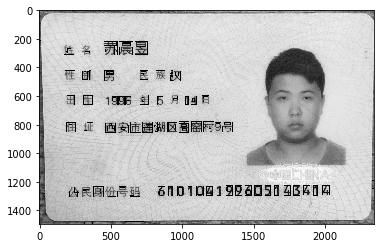

In [32]:
plt.imshow(dst,'gray')

In [22]:
text = pytesseract.image_to_string(gray,lang='chi_sim')

In [23]:
print(text)

姓 名 苏晨明
性 别 男. 民族汉
出-本 -1996 年.5 月讨昌

住 址 西安市莲湖区高窗村9号

 

”公民身份号码 610104199605143414

四


In [34]:
import cv2
import scipy.misc as smp

import numpy as np
import pprint
from pytesseract import image_to_string 
from PIL import Image


color = (0,255,0)
char_height = 20.0

def bbox(points):
    res = np.zeros((2,2))
    res[0,:] = np.min(points, axis=0)
    res[1,:] = np.max(points, axis=0)
    return res

def bbox_width(bbox):
    return (bbox[1,0] - bbox[0,0] + 1)

def bbox_height(bbox):
    return (bbox[1,1] - bbox[0,1] +1)

def aspect_ratio(region):
    bb = bbox(region)
    return (bbox_width(bb)/bbox_height(bb))


def filter_on_ar(regions):
    #Filter text regions based on Aspect-ratio 
    return [x for x in regions if aspect_ratio(x)]

def dbg_draw_txt_contours(img, mser):
    overlapped_img = cv2.drawContours(img, mser, -1, color)
    new_img = smp.toimage(overlapped_img)
    new_img = np.array(new_img)
    #new_img.show()
    
def dbg_draw_txt_rect(img, bbox_list):
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR, dstCn=3)
    processed_imgname="../temp/MSER_refinement.png"
    #scratch_image_name = 'nutro.tmp.bmp'
    for b in bbox_list:
        pt1 = tuple(map(int, b[0]))
        pt2 = tuple(map(int, b[1]))
        img = cv2.rectangle(img, pt1, pt2, color, 1)
            #break
    new_img = smp.toimage(img)
    new_img = np.array(new_img)
    cv2.imwrite(processed_imgname, new_img)
   
    
def preprocess_img(img):
    #Enhance contrast and resize the image 
    # create a CLAHE object (Arguments are optional).
    # It is adaptive localized hist-eq and also avoid noise
    # amplification with cliplimit
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize = (8,8))
    img = clahe.apply(img)
    # Resize to match SVGA size
    height, width = img.shape
    # SVGA size is 800x600
    if width & height:
        scale = 800. /width
    else:
        scale = 600. /width
        
    #Avoid shrinking
    #if scale &amp; amp; amp; amp; lt; 1.0:
    #   scale = 1.0
    dst = cv2.resize(img, (0,0), None, scale, scale, cv2.INTER_LINEAR)
    return dst

def swt_window_func(l):
    center = l[4]
    filtered_l = np.append(l[:4], l[5:])
    res = [n for n in filtered_l if n & center]
    return res

def swt(gimg):
    #TODO: fix threshold logically
    threshold = 90
    maxval = 255
    #THRESH_BINARY_INV because we want to find distance from foreground pixel to background pixel
    temp, bimg = cv2.threshold(gimg, threshold, maxval, cv2.THRESH_BINARY_INV)
    rows, cols = bimg.shape
    #Pad 0 pixel on bottom-row to avoid Infinite distance
    row_2_pad = np.zeros([1, cols], dtype=np.uint8)
    bimg_padded = np.concatenate((bimg, row_2_pad), axis=0)
    dist = cv2.distanceTransform(bimg_padded, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
    dist = np.take(dist, range(rows), axis=0)
    dist = dist.round()
    #print dist
    it = np.nditer([bimg, dist],
                   op_flags=[['readonly'],['readonly']],
                   flags = ['multi_index', 'multi_index'])
 
    #Look-up operation
    #while not it.finished:
    lookup = []
    max_col = 0
    max_row = 0
    for cur_b, cur_d in it:
        if it.multi_index[0]<max_row:
            max_row = it.multi_index[0]
        if it.multi_index[1]<max_col:
            max_col = it.multi_index[1]
        if cur_b:
            cur_lup = []
            pval = cur_d
            row = it.multi_index[0]
            if row!=0:
                row_l = row-1
            else:
                row_l = row
            if row!=rows-1:
                row_u = row+1
            else:
                row_u = row
            row_list = [row_l, row, row_u]
            col = it.multi_index[1]
            if col!=0:
                col_l = col-1
            else:
                col_l = col
            if col!=cols-1:
                col_u = col+1
            else:
                col_u = col
            col_list = [col_l, col, col_u]
            #TODO: avoid for loop for look-up operation
            for i in row_list:
                for j in col_list:
                    if i!=row and j!=col:
                        cur = dist[i,j]
                        if cur > pval:
                            cur_lup.append((i,j))
            lookup.append(cur_lup)
        else:
            lookup.append(None)
        #it.iternext()
    lookup = np.array(lookup)
    lookup= lookup.reshape(rows, cols)
    d_max = int(dist.max())
    for stroke in np.arange(d_max, 0, -1):
        stroke_index = np.where(dist==stroke)
        stroke_index = [(a,b) for a,b in zip(stroke_index[0], stroke_index[1])]
        for stidx in stroke_index:
            neigh_index = lookup[stidx]
            for nidx in neigh_index:
                dist[nidx] = stroke
 
    it.reset()
    sw = []
    for cur_b, cur_d in it:
        if cur_b:
            sw.append(cur_d)
    return sw

def get_swt_frm_mser(region, rows, cols, img):
    #Given image and total rows and columns, extract SWT values from MSER region
    bb = bbox(region)
    xmin = int(bb[0][0])
    ymin = int(bb[0][1])
    width = int(bbox_width(bb))
    height = int(bbox_height(bb))
    selected_pix = []
    xmax = xmin + width
    ymax = ymin + height
    for h in range(ymin, ymax):
        row = np.take(img, (h, ), axis=0)
        horz_pix = np.take(row, range(xmin,xmax))
        selected_pix.append(horz_pix)
    selected_pix = np.array(selected_pix)
    sw = swt(selected_pix)
    return sw

def filter_on_sw(region_dict):
    filtered_dict = {}
    distance_th = 4.0
    group_num = 0
    for rkey in region_dict.keys():
        med = region_dict[rkey]['sw_med']
        height = bbox_height(region_dict[rkey]['bbox'])
        added = False
        for fkey in filtered_dict:
            for k in filtered_dict[fkey]:
                elem_med = filtered_dict[fkey][k]['sw_med']
                elem_height = bbox_height(filtered_dict[fkey][k]['bbox'])
                m_ratio = med/elem_med
                h_ratio = height/elem_height
                if m_ratio < 0.66 and m_ratio < 1.5 and h_ratio < 2.0:
                    filtered_dict[fkey][rkey] = region_dict[rkey]
                    added = True
                    break
            if added:
                break
        if not added:
            name = 'group' + str(group_num)
            filtered_dict[name] = {}
            filtered_dict[name][rkey] = region_dict[rkey]
            group_num = group_num +1
    return filtered_dict

def get_y_center(bb):
    ll = bb[0]
    ur = bb[1]
    return ((ll[1]+ur[1])/2.0)

def kmean(region_dict, rows, num_clusters):
    clusters = (float(rows)/num_clusters) * np.arange(num_clusters)
    cluster_vld = [True] * num_clusters
    #calculate initial cost assuming all regions assigned to cluster-0
    cost = 0.0
    for rkey in region_dict:
        center_y = get_y_center(region_dict[rkey]['bbox'])
        cost += center_y * center_y
    cost = cost/len(region_dict.keys())
 
    iter_no = 0
    while True:
        iter_no = iter_no + 1
        #Assign cluster-id to each region
        for rkey in region_dict:
            center_y = get_y_center(region_dict[rkey]['bbox'])
            dist_y = np.abs(clusters - center_y)
            cluster_id = dist_y.argmin()
            region_dict[rkey]['clid'] = cluster_id
 
        #find new cost with assigned clusters
        new_cost = 0.0
        for i, c in enumerate(clusters):
            if cluster_vld[i]:
                num_regions = 0
                cluster_cost = 0.0
                for rkey in region_dict:
                    if(region_dict[rkey]['clid'] == i):
                        center_y = get_y_center(region_dict[rkey]['bbox'])
                        cluster_cost += (center_y - clusters[i]) ** 2
                        num_regions += 1
                if num_regions:
                    cluster_cost /= num_regions
            new_cost += cluster_cost
 
        #Stop when new cost is within 5% of old cost
        if new_cost >= 0.95 * cost:
            break
        else:
            cost = new_cost
 
        for i, c in enumerate(clusters):
            if cluster_vld[i]:
                num_regions = 0
                clusters[i] = 0.0
                for rkey in region_dict:
                    if(region_dict[rkey]['clid'] == i):
                        center_y = get_y_center(region_dict[rkey]['bbox'])
                        clusters[i] += center_y
                        num_regions += 1
                if num_regions:
                    clusters[i] = clusters[i] / num_regions
                else:
                    cluster_vld[i] = False
 
    #Merge nearby clusters
    for i, cur_cl in enumerate(clusters):
        if cluster_vld[i]:
            for j, iter_cl in enumerate(clusters):
                if abs(cur_cl - iter_cl) <= (char_height/2.0) and i != j:
                    cluster_vld[j] = False
                    for rkey in region_dict:
                        #Update cluster-id to updated one
                        if region_dict[rkey]['clid'] == j:
                            region_dict[rkey]['clid'] = i
 
    return cluster_vld
    
def dbg_get_cluster_rect(cluster_vld, region_dict):
    bbox_list = []
    vld_count = 0
    for cl_no, vld in enumerate(cluster_vld):
        if vld==True:
            vld_count+=1
        print ("vld")
        print (vld)
        if vld:
            cur_lL = [100000, 10000]
            cur_uR = [-100000, -100000]
            for rkey in region_dict.keys():
                if region_dict[rkey]['clid'] == cl_no:
                    region_lL = region_dict[rkey]['bbox'][0]
                    region_uR = region_dict[rkey]['bbox'][1]
                    #update min/max of x/y
                    if region_lL[0] <= cur_lL[0]:
                        cur_lL[0] = region_lL[0]
                    if region_lL[1] <= cur_lL[1]:
                        cur_lL[1] = region_lL[1]
                    if region_uR[0] >= cur_uR[0]:
                        cur_uR[0] = region_uR[0]
                    if region_uR[1] >= cur_uR[1]:
                        cur_uR[1] = region_uR[1]
            bbox_list.append([cur_lL, cur_uR])
    print ("len(bbox_list) in get_text_from_cluster")
    print (len(bbox_list))
    print ("vld_count")
    print (vld_count)
    return bbox_list
            
def get_bbox_img(gimg, bb):
    #print bb, gimg.shape
    y_start = int(bb[0][1])
    y_end   = int(bb[1][1])
    x_start = int(bb[0][0])
    x_end   = int(bb[1][0])
    #print x_start, x_end, y_start, y_end
    row_extracted = gimg.take(range(y_start, y_end+1), axis=0)
    #print gimg
    extracted = row_extracted.take(range(x_start, x_end+1), axis=1)
    
    return extracted

def get_text_from_cluster(cluster_vld, region_dict, gimg):
    bbox_list = dbg_get_cluster_rect(cluster_vld, region_dict)
    str_list = ""
    for bb in bbox_list:
        extracted = get_bbox_img(gimg, bb)
        ext_img = smp.toimage(extracted)
        found = image_to_string(ext_img,lang='chi_sim')
        str_list = str_list + found.strip() + "\r\n"
    print ("results :___________________________________")
    print ("%s" % str_list)

    
def run(fimage):
    processed_imgname='../temp/ID.jpg'
    ar_thresh_max = 6.0
    ar_thresh_min = 0.5
    sw_ratio_thresh = 0.8
    min_area_ratio = 500.0
    width_threshold = 5.0
    
    org_img = cv2.imread(fimage)
    gray_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2GRAY)
    mser = cv2.MSER_create()
    mser.setDelta(4)
    mser_areas, _ = mser.detectRegions(gray_img)
    region_dict = {}
    rows, cols = gray_img.shape
    print("the shape of gray image is ")
    print (rows, cols)
    
    bbox_list = []
    region_num = 0
    for m in mser_areas:
        name = 'mser_' + str(region_num)
       # print("mser name")
       # print name
        bb = bbox(m)
       # print bb
        ar = bbox_width(bb)/bbox_height(bb)
        area_ratio=bbox_width(bb)*bbox_height(bb)
        print ("area_ratio")
        print (area_ratio)
        print("ar is")
        print (ar)
        #Filter based on AspectRatio
        if ar < ar_thresh_max and area_ratio>min_area_ratio and ar > ar_thresh_min and bbox_width(bb)>width_threshold:
            sw = get_swt_frm_mser(m, rows, cols, gray_img)
            sw_std  = np.std(sw)
            sw_mean = np.mean(sw)
            sw_ratio = sw_std/sw_mean
            # Filter based on Stroke-width
          #  print "sw_ratio"
           # print sw_ratio
            if sw_ratio < sw_ratio_thresh:
                print ("sw_ratio")
                print (sw_ratio)
                sw_med = np.median(sw)
                region_dict[name] = {'bbox':bb, 'sw_med':sw_med};
                region_num = region_num +1
    
    print ("region_num")
    print (region_num)
     
    print ("rows number")
    print (rows)
    print ("char_height")
    print (char_height)
    num_clusters = int(rows/char_height)
    cluster_vld  = kmean(region_dict, rows, num_clusters)
    print ("len(cluster_vld)")
    print (len(cluster_vld))
    bbox_list = dbg_get_cluster_rect(cluster_vld, region_dict)
    print ("len(bbox_list) after clustering")
    print (len(bbox_list))
    for bb in bbox_list:
        print (bb)
    
    #get_text_from_cluster(cluster_vld, region_dict, gray_img)
    print ("len(region_dict)")
    print (len(region_dict))
    print ("gray_img.shape")
    print (gray_img.shape)
    cpy_img = np.copy(gray_img)
    dbg_draw_txt_rect(cpy_img, bbox_list)
    get_text_from_cluster(cluster_vld, region_dict, org_img)
    
  

    
if __name__ == '__main__':
    img_name = "../datas/ID.jpg"
    #img_name = "/home/lili/Workspace/MSER_images/MSER2/good_ex.png"
    run(img_name)

the shape of gray image is 
711 1104
area_ratio
494.0
ar is
1.368421052631579
area_ratio
494.0
ar is
1.368421052631579
area_ratio
494.0
ar is
1.368421052631579
area_ratio
520.0
ar is
1.3
sw_ratio
0.2748926
area_ratio
546.0
ar is
1.2380952380952381
sw_ratio
0.27130878
area_ratio
546.0
ar is
1.2380952380952381
sw_ratio
0.27130878
area_ratio
546.0
ar is
1.2380952380952381
sw_ratio
0.27130878
area_ratio
588.0
ar is
1.3333333333333333
sw_ratio
0.29653272
area_ratio
588.0
ar is
1.3333333333333333
sw_ratio
0.29653272
area_ratio
221.0
ar is
0.7647058823529411
area_ratio
255.0
ar is
0.8823529411764706
area_ratio
255.0
ar is
0.8823529411764706
area_ratio
270.0
ar is
0.8333333333333334
area_ratio
270.0
ar is
0.8333333333333334
area_ratio
304.0
ar is
0.8421052631578947
area_ratio
304.0
ar is
0.8421052631578947
area_ratio
304.0
ar is
0.8421052631578947
area_ratio
304.0
ar is
0.8421052631578947
area_ratio
252.0
ar is
0.7777777777777778
area_ratio
252.0
ar is
0.7777777777777778
area_ratio
288.0
ar is

sw_ratio
0.31391788
area_ratio
1118.0
ar is
0.6046511627906976
sw_ratio
0.31391788
area_ratio
90.0
ar is
0.9
area_ratio
1156.0
ar is
1.0
sw_ratio
0.15022103
area_ratio
1190.0
ar is
1.0294117647058822
sw_ratio
0.14962079
area_ratio
1190.0
ar is
1.0294117647058822
sw_ratio
0.14962079
area_ratio
1190.0
ar is
1.0294117647058822
sw_ratio
0.14962079
area_ratio
1190.0
ar is
1.0294117647058822
sw_ratio
0.14962079
area_ratio
1190.0
ar is
1.0294117647058822
sw_ratio
0.14962079
area_ratio
1296.0
ar is
1.0
sw_ratio
0.1493827
area_ratio
1332.0
ar is
1.0277777777777777
sw_ratio
0.1493827
area_ratio
1332.0
ar is
1.0277777777777777
sw_ratio
0.1493827
area_ratio
1332.0
ar is
1.0277777777777777
sw_ratio
0.1493827
area_ratio
1368.0
ar is
1.0555555555555556
sw_ratio
0.1493827
area_ratio
1368.0
ar is
1.0555555555555556
sw_ratio
0.1493827
area_ratio
910.0
ar is
0.7428571428571429
sw_ratio
0.31445307
area_ratio
910.0
ar is
0.7428571428571429
sw_ratio
0.31445307
area_ratio
910.0
ar is
0.7428571428571429
sw_ra

sw_ratio
0.0
area_ratio
576.0
ar is
1.7777777777777777
sw_ratio
0.0
area_ratio
299.0
ar is
1.7692307692307692
area_ratio
345.0
ar is
1.5333333333333334
area_ratio
345.0
ar is
1.5333333333333334
area_ratio
360.0
ar is
1.6
area_ratio
360.0
ar is
1.6
area_ratio
360.0
ar is
1.6
area_ratio
360.0
ar is
1.6
area_ratio
360.0
ar is
1.6
area_ratio
360.0
ar is
1.6
area_ratio
360.0
ar is
1.6
area_ratio
360.0
ar is
1.6
area_ratio
360.0
ar is
1.6
area_ratio
540.0
ar is
0.7407407407407407
sw_ratio
0.0
area_ratio
609.0
ar is
0.7241379310344828
sw_ratio
0.0
area_ratio
638.0
ar is
0.7586206896551724
sw_ratio
0.0
area_ratio
275.0
ar is
0.44
area_ratio
275.0
ar is
0.44
area_ratio
300.0
ar is
0.48
area_ratio
300.0
ar is
0.48
area_ratio
300.0
ar is
0.48
area_ratio
928.0
ar is
1.103448275862069
sw_ratio
0.0
area_ratio
928.0
ar is
1.103448275862069
sw_ratio
0.0
area_ratio
957.0
ar is
1.1379310344827587
sw_ratio
0.0
area_ratio
957.0
ar is
1.1379310344827587
sw_ratio
0.0
area_ratio
957.0
ar is
1.137931034482758

sw_ratio
0.0
area_ratio
551.0
ar is
0.6551724137931034
sw_ratio
0.0
area_ratio
609.0
ar is
0.7241379310344828
sw_ratio
0.0
area_ratio
630.0
ar is
0.7
sw_ratio
0.0
area_ratio
627.0
ar is
1.736842105263158
sw_ratio
0.23328613
area_ratio
627.0
ar is
1.736842105263158
sw_ratio
0.23328613
area_ratio
627.0
ar is
1.736842105263158
sw_ratio
0.23328613
area_ratio
627.0
ar is
1.736842105263158
sw_ratio
0.23328613
area_ratio
627.0
ar is
1.736842105263158
sw_ratio
0.23328613
area_ratio
627.0
ar is
1.736842105263158
sw_ratio
0.23328613
area_ratio
627.0
ar is
1.736842105263158
sw_ratio
0.23328613
area_ratio
680.0
ar is
1.7
sw_ratio
0.23328613
area_ratio
680.0
ar is
1.7
sw_ratio
0.23328613
area_ratio
210.0
ar is
2.1
area_ratio
231.0
ar is
1.9090909090909092
area_ratio
231.0
ar is
1.9090909090909092
area_ratio
231.0
ar is
1.9090909090909092
area_ratio
231.0
ar is
1.9090909090909092
area_ratio
231.0
ar is
1.9090909090909092
area_ratio
231.0
ar is
1.9090909090909092
area_ratio
231.0
ar is
1.909090909090

sw_ratio
0.0
area_ratio
1406.0
ar is
1.027027027027027
sw_ratio
0.0
area_ratio
1224.0
ar is
1.0588235294117647
sw_ratio
0.0
area_ratio
1224.0
ar is
1.0588235294117647
sw_ratio
0.0
area_ratio
1224.0
ar is
1.0588235294117647
sw_ratio
0.0
area_ratio
1224.0
ar is
1.0588235294117647
sw_ratio
0.0
area_ratio
1224.0
ar is
1.0588235294117647
sw_ratio
0.0
area_ratio
1224.0
ar is
1.0588235294117647
sw_ratio
0.0
area_ratio
1224.0
ar is
1.0588235294117647
sw_ratio
0.0
area_ratio
1258.0
ar is
1.088235294117647
sw_ratio
0.0
area_ratio
1258.0
ar is
1.088235294117647
sw_ratio
0.0
area_ratio
1258.0
ar is
1.088235294117647
sw_ratio
0.0
area_ratio
1258.0
ar is
1.088235294117647
sw_ratio
0.0
area_ratio
1332.0
ar is
1.0277777777777777
sw_ratio
0.0
area_ratio
1332.0
ar is
1.0277777777777777
sw_ratio
0.0
area_ratio
1332.0
ar is
1.0277777777777777
sw_ratio
0.0
area_ratio
1332.0
ar is
1.0277777777777777
sw_ratio
0.0
area_ratio
1332.0
ar is
1.0277777777777777
sw_ratio
0.0
area_ratio
1332.0
ar is
1.02777777777777

sw_ratio
0.0
area_ratio
735.0
ar is
0.6
sw_ratio
0.0
area_ratio
735.0
ar is
0.6
sw_ratio
0.0
area_ratio
735.0
ar is
0.6
sw_ratio
0.0
area_ratio
392.0
ar is
0.5
area_ratio
1120.0
ar is
0.9142857142857143
sw_ratio
0.0
area_ratio
1190.0
ar is
0.9714285714285714
sw_ratio
0.0
area_ratio
1225.0
ar is
1.0
sw_ratio
0.0
area_ratio
1260.0
ar is
0.9722222222222222
sw_ratio
0.0
area_ratio
1296.0
ar is
1.0
sw_ratio
0.0
area_ratio
1156.0
ar is
1.0
sw_ratio
0.0
area_ratio
1190.0
ar is
1.0294117647058822
sw_ratio
0.0
area_ratio
1190.0
ar is
1.0294117647058822
sw_ratio
0.0
area_ratio
1190.0
ar is
1.0294117647058822
sw_ratio
0.0
area_ratio
1190.0
ar is
1.0294117647058822
sw_ratio
0.0
area_ratio
1190.0
ar is
1.0294117647058822
sw_ratio
0.0
area_ratio
1190.0
ar is
1.0294117647058822
sw_ratio
0.0
area_ratio
1225.0
ar is
1.0
sw_ratio
0.0
area_ratio
1225.0
ar is
1.0
sw_ratio
0.0
area_ratio
1225.0
ar is
1.0
sw_ratio
0.0
area_ratio
1225.0
ar is
1.0
sw_ratio
0.0
area_ratio
1225.0
ar is
1.0
sw_ratio
0.0
area_rat

area_ratio
1332.0
ar is
1.0277777777777777
sw_ratio
0.0
area_ratio
1332.0
ar is
1.0277777777777777
sw_ratio
0.0
area_ratio
1332.0
ar is
1.0277777777777777
sw_ratio
0.0
area_ratio
1332.0
ar is
1.0277777777777777
sw_ratio
0.0
area_ratio
1088.0
ar is
0.9411764705882353
sw_ratio
0.0
area_ratio
1088.0
ar is
0.9411764705882353
sw_ratio
0.0
area_ratio
1088.0
ar is
0.9411764705882353
sw_ratio
0.0
area_ratio
1088.0
ar is
0.9411764705882353
sw_ratio
0.0
area_ratio
1088.0
ar is
0.9411764705882353
sw_ratio
0.0
area_ratio
1088.0
ar is
0.9411764705882353
sw_ratio
0.0
area_ratio
1088.0
ar is
0.9411764705882353
sw_ratio
0.0
area_ratio
1088.0
ar is
0.9411764705882353
sw_ratio
0.0
area_ratio
1122.0
ar is
0.9705882352941176
sw_ratio
0.0
area_ratio
1155.0
ar is
0.9428571428571428
sw_ratio
0.0
area_ratio
1155.0
ar is
0.9428571428571428
sw_ratio
0.0
area_ratio
1155.0
ar is
0.9428571428571428
sw_ratio
0.0
area_ratio
1155.0
ar is
0.9428571428571428
sw_ratio
0.0
area_ratio
1155.0
ar is
0.9428571428571428
sw_ra

C:\Users\jenson\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\jenson\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\jenson\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\jenson\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\jenson\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


sw_ratio
0.0
area_ratio
1665.0
ar is
1.2162162162162162
sw_ratio
0.0
area_ratio
1872.0
ar is
1.2307692307692308
sw_ratio
0.0
area_ratio
870.0
ar is
0.9666666666666667
sw_ratio
0.0
area_ratio
870.0
ar is
0.9666666666666667
sw_ratio
0.0
area_ratio
899.0
ar is
0.9354838709677419
sw_ratio
0.0
area_ratio
899.0
ar is
0.9354838709677419
sw_ratio
0.0
area_ratio
928.0
ar is
0.90625
sw_ratio
0.0
area_ratio
928.0
ar is
0.90625
sw_ratio
0.0
area_ratio
928.0
ar is
0.90625
sw_ratio
0.0
area_ratio
928.0
ar is
0.90625
sw_ratio
0.0
area_ratio
928.0
ar is
0.90625
sw_ratio
0.0
area_ratio
928.0
ar is
0.90625
sw_ratio
0.0
area_ratio
928.0
ar is
0.90625
sw_ratio
0.0
area_ratio
928.0
ar is
0.90625
sw_ratio
0.0
area_ratio
928.0
ar is
0.90625
sw_ratio
0.0
area_ratio
928.0
ar is
0.90625
sw_ratio
0.0
area_ratio
957.0
ar is
0.8787878787878788
sw_ratio
0.0
area_ratio
957.0
ar is
0.8787878787878788
sw_ratio
0.0
area_ratio
957.0
ar is
0.8787878787878788
sw_ratio
0.0
area_ratio
957.0
ar is
0.8787878787878788
sw_ratio

C:\Users\jenson\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
C:\Users\jenson\Anaconda3\lib\site-packages\ipykernel_launcher.py:328: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


results :___________________________________




四734-和车 5 月26
佳 址 云南省昆明市寻旬回族王
au     人         二
族自治县羊街镇纳郎村委 硬、 -售
会纳郎村72号

全民导份己码 23c2311974052613533

